In [281]:
import pandas as pd 
import numpy as np 
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('seaborn')

# Load data

In [4]:
dfc = pd.read_csv("population_communes.csv")
dfd = pd.read_csv("surface_departements.csv")

In [132]:
dfc.head(2)

,Code département,Code canton,Code arrondissement,Code région,Nom de la commune,Code commune,Nom de la région,variable,value
0,64,27.0,3,75,Aast,1,Nouvelle-Aquitaine,Population totale,184
1,64,27.0,3,75,Aast,1,Nouvelle-Aquitaine,Population municipale,177


# Group values by department

In [263]:
df_1 = dfc.groupby(["Code département", "variable"]).sum()[['value']]

In [264]:
df_1.head()

value
Code département variable                     
01               Population municipale  638425
                 Population totale      655171
02               Population municipale  536136
                 Population totale      549587
03               Population municipale  339384

## Unstack index and set one level index for columns

In [265]:
df_1 = df_1.unstack()

In [266]:
df_1.columns = df_1.columns.droplevel(level=0)

In [267]:
df_1.columns = df_1.columns.set_names([None])

In [268]:
df_1.head()

,Population municipale,Population totale
Code département,,
01,638425,655171
02,536136,549587
03,339384,349336
04,162565,167331
05,141107,146148


# Compute % municipal polulation

In [269]:
df_1["% municipal"] = 100 -(df_1["Population totale"] - df_1["Population municipale"])\
                            /df_1["Population totale"] *100

In [270]:
df_1.head()

,Population municipale,Population totale,% municipal
Code département,,,
01,638425,655171,97.444026
02,536136,549587,97.552526
03,339384,349336,97.151167
04,162565,167331,97.151753
05,141107,146148,96.550757


# Join the region and compute the % municipal population per region

In [271]:
df_1 = df_1.merge(dfc[["Code région", "Code département"]].drop_duplicates(), left_on=['Code département'], right_on=['Code département'], how='inner')

In [272]:
df_1["% region"] = 100 *df_1["Population municipale"] / df_1.groupby('Code région').transform('sum')['Population municipale'] 

In [273]:
df_1.head()

,Code département,Population municipale,Population totale,% municipal,Code région,% region
0,01,638425,655171,97.444026,84,8.06409
1,02,536136,549587,97.552526,32,8.92538
2,03,339384,349336,97.151167,84,4.28684
3,04,162565,167331,97.151753,93,3.2371
4,05,141107,146148,96.550757,93,2.80982


In [274]:
df_1[["% region", "Code région"]].groupby(["Code région"]).sum().head()

,% region
Code région,
1,100.0
2,100.0
3,100.0
4,100.0
11,100.0


In [275]:
dfd

,code_insee,nom,surf_km2
0,974,La Réunion,2505.0
1,11,Aude,6343.0
2,43,Haute-Loire,5003.0
3,13,Bouches-du-Rhône,5247.0
4,47,Lot-et-Garonne,5385.0
...,...,...,...
96,56,Morbihan,6870.0
97,25,Doubs,5256.0
98,39,Jura,5049.0
99,07,Ardèche,5566.0


In [276]:
df = df_1.merge(dfd, left_on=["Code département"], right_on=["code_insee"], copy=False)

In [277]:
df.drop(['code_insee'], axis=1)
df["densité"] = df["Population municipale"]/df["surf_km2"]

# Dataframe final

In [278]:
df.head()

,Code département,Population municipale,Population totale,% municipal,Code région,% region,code_insee,nom,surf_km2,densité
0,01,638425,655171,97.444026,84,8.06409,01,Ain,5784.0,110.377766
1,02,536136,549587,97.552526,32,8.92538,02,Aisne,7411.0,72.343274
2,03,339384,349336,97.151167,84,4.28684,03,Allier,7379.0,45.993224
3,04,162565,167331,97.151753,93,3.2371,04,Alpes-de-Haute-Provence,6993.0,23.246818
4,05,141107,146148,96.550757,93,2.80982,05,Hautes-Alpes,5697.0,24.768650


In [279]:
col = df.columns.tolist()
col_reshape = [col[0]] + [col[-3]] + col[1:2] + [col[-1]]
df = df[col_reshape]
df

,Code département,nom,Population municipale,densité
0,01,Ain,638425,110.377766
1,02,Aisne,536136,72.343274
2,03,Allier,339384,45.993224
3,04,Alpes-de-Haute-Provence,162565,23.246818
4,05,Hautes-Alpes,141107,24.768650
...,...,...,...,...
95,95,Val-d'Oise,1221923,975.197925
96,971,Guadeloupe,394110,241.193390
97,972,Martinique,376480,345.711662
98,973,Guyane,269352,3.224112


In [286]:
dpts_shape = gpd.read_file('./depts-shp/departements-20180101.shp')

In [289]:
dpts = dpts_shape.merge(df.rename(columns={
    'nom': 'nom',
    'Population municipale': 'pop',
}))[['Code département', 'nom', 'geometry', 'pop']]

In [298]:
paris = dpts[dpts.nom == 'Paris'].iloc[0].geometry.centroid
dpts = dpts[dpts.geometry.distance(paris) < 10]
dpts = dpts.to_crs({'init': 'epsg:3395'})  # mercator projection

Text(0.5, 1, 'Population par département')

<Figure size 576x396 with 0 Axes>

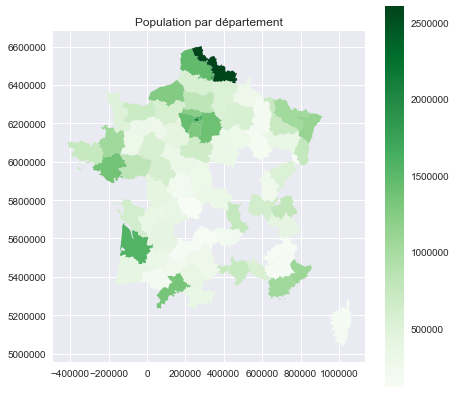

In [301]:
plt.figure()

p = dpts.plot(column='pop',
    figsize=(7, 7),
    legend=True,
    cmap='Greens',
)

plt.title('Population par département')